In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import os
import scipy
import scipy.io as sio
from scipy.integrate import solve_ivp, odeint
from utility_functions import sparsifyDynamics, poolData

### Load Data and Scale 

In [2]:
# load saved data from .mat file
data = sio.loadmat('../models/data/REFSIM-25hr.mat', chars_as_strings=1)
t = data['t']
x = data['x']
names = data['names']
names = np.array([str(''.join(letter)) for letter_array in names for letter in letter_array])
# print(names)

# only keep non-constant data
dynamics = [0,1,2,3,4,5,6,7,8,9]
x = x[:, dynamics]
names = names[dynamics]
names = ['Arterial', 'Gut', 'GutLumen', 'Lung', 'Venous', 'Rest', 'Liver', 'Metab', 'Kidney', 'Tubules']

# scale all data from Mols/L to milliMols/L (which equals microMol/mL)
x *= 1000

### Plot Data

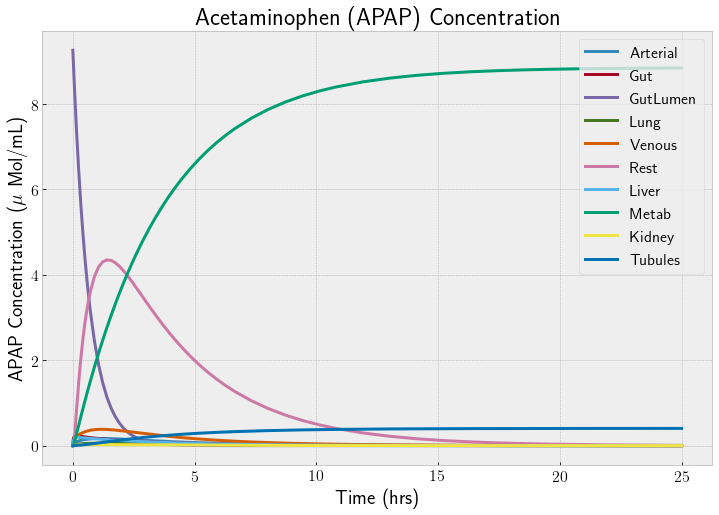

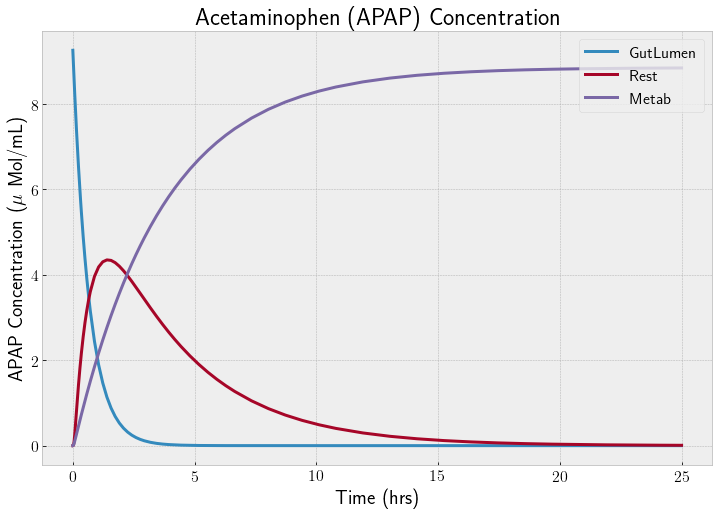

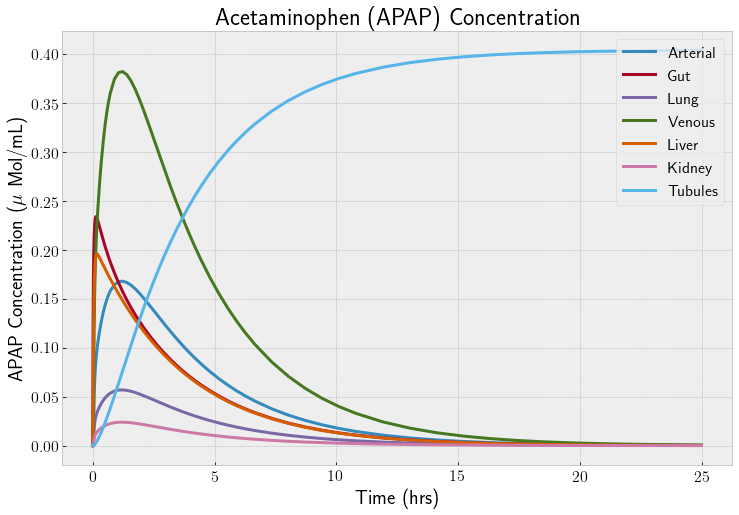

In [3]:
# change plot display style
# plt.style.use('dark_background')
# plt.style.use('classic')
plt.style.use('bmh')
# plt.style.use('seaborn-dark')
# print(plt.style.available)
plt.rcParams['font.size'] = 22
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 10
plt.rcParams['text.usetex'] = True

# plot the amount of APAP in venous blood over time
# venousAPAPInLiters = x[:, 5] / 3.41;
# fig, ax = plt.subplots(figsize=(12,8))
# ax.plot(t, venousAPAPInLiters)
# plt.xlabel('Time (hrs)')
# plt.ylabel(names[5] + r' APAP ($\mu$ Mol/mL)')
# plt.title('Acetaminophen (APAP) Metabolism')
# plt.show()

compartments = dynamics

# Create plots with pre-defined labels.
fig, ax = plt.subplots(figsize=(12,8))
for c in compartments:
      ax.plot(t, x[:, c], label=names[c])
plt.xlabel('Time (hrs)')
plt.ylabel(r'APAP Concentration ($\mu$ Mol/mL)')
plt.title('Acetaminophen (APAP) Concentration')
ax.legend(loc='upper right')
plt.show()

compartments = [2,5,7]

# Create plots with pre-defined labels.
fig, ax = plt.subplots(figsize=(12,8))
for c in compartments:
      ax.plot(t, x[:, c], label=names[c])
plt.xlabel('Time (hrs)')
plt.ylabel(r'APAP Concentration ($\mu$ Mol/mL)')
plt.title('Acetaminophen (APAP) Concentration')
ax.legend(loc='upper right')
plt.show()

compartments = [0,1,3,4,6,8,9]

# Create plots with pre-defined labels.
fig, ax = plt.subplots(figsize=(12,8))
for c in compartments:
      ax.plot(t, x[:, c], label=names[c])
plt.xlabel('Time (hrs)')
plt.ylabel(r'APAP Concentration ($\mu$ Mol/mL)')
plt.title('Acetaminophen (APAP) Concentration')
ax.legend(loc='upper right')
plt.show()

### Run SINDy Algorithm

In [84]:
# Run SINDy algorithm
xdf = pd.DataFrame(x)
n, nVars = x.shape
xdf_dot = xdf.diff()

# we lose one row, need to zero pad (or maybe not)
#x_dot = pd.concat([pd.DataFrame(np.zeros((1, nVars))), x_dot])
xdf_dot.loc[0, :] = 0.0

# variable labeling
cols = [i for i in names]
xdf.columns = cols
dot_labels = pd.Index([s for s in cols])

# SINDy params
polyorder = 3
lam = 0.0001
usesine = 0

# generate data
Theta = pd.DataFrame()
Theta = poolData(xdf, nVars, polyorder, usesine)

# run SINDy
xdf_hat = sparsifyDynamics(Theta, xdf_dot, lam)
xdf_hat = xdf_hat.set_index(dot_labels)
print(xdf_hat.shape)


(10, 286)


/home/john/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


### Display Results and Save

In [85]:
# Save to csv
xdf_hat.to_csv('../models/data/dynamics.csv')
# Display results except rows that have all zeros
xdf_hat.T.loc[(xdf_hat.T!=0).any(axis=1)]

,Arterial,Gut,GutLumen,Lung,Venous,Rest,Liver,Metab,Kidney,Tubules
GutLumen,0.000000,0.000000,-0.000000,0.0,0.000000,0.000000,0.000000e+00,-0.000000,0.0,-0.000067
Rest,-0.000000,-0.000669,0.000000,-0.0,-0.000000,-0.000000,-6.159823e-04,0.000000,-0.0,0.000000
Metab,-0.000000,-0.000000,0.000000,-0.0,-0.000000,-0.001971,-0.000000e+00,0.000000,-0.0,0.000000
Kidney,0.000000,-0.083958,-0.000000,0.0,0.000000,0.000000,-0.000000e+00,0.000000,0.0,0.000000
"(Gut, GutLumen)",0.000000,0.000000,-0.008095,0.0,0.002563,0.000000,0.000000e+00,0.000000,0.0,-0.000000
"(Gut, Metab)",-0.000000,-0.000000,0.000000,-0.0,-0.000000,-0.000000,-2.183186e-03,0.000000,-0.0,0.000000
"(Gut, Tubules)",-0.000000,-0.000000,0.000000,-0.0,-0.000000,-0.000000,-0.000000e+00,0.000000,-0.0,0.370972
"(GutLumen, Venous)",0.000799,-0.000000,-0.000000,0.0,0.002815,0.000000,-0.000000e+00,0.000000,0.0,-0.000000
"(GutLumen, Liver)",0.001478,0.000000,-0.000000,0.0,0.000743,0.000000,0.000000e+00,0.000000,0.0,-0.000000
"(Liver, Metab)",-0.000000,-0.000000,0.000000,-0.0,-0.000000,-0.000000,-0.000000e+00,0.000000,-0.0,0.005938


### Use SINDy Results (Verification Simulation)

In [86]:
def sparseGalerkin(y, t):
    ydf = pd.DataFrame(np.array(y))
    yPool = poolData(ydf.T, len(y), polyorder, usesine)
    x1 = np.array(yPool)
    x2 = np.array(xdf_hat).T
    X = np.matmul(x1, x2)
    dy = pd.DataFrame(X).T.squeeze()
    return dy

timespan = np.linspace(0, 3600 * 25, len(t))
y0 = np.array(xdf.iloc[0, :])

xB = odeint(sparseGalerkin, y0, timespan)
print(xB.shape)
print(xB)

# tB, xB = solve_ivp(sparseGalerkin, timespan, y0)


(130, 10)
[[0.00000000e+000 0.00000000e+000 9.25925926e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [1.17442040e+000 3.92542198e+000 8.81161399e-002 ... 1.63437598e+002
  0.00000000e+000 1.26575141e+000]
 [2.61356260e-316 2.61356458e-316 1.06099790e-313 ... 1.38338381e-322
  6.91117005e-310 2.97079411e-313]
 ...
 [6.01347002e-154 1.30355150e-076 4.47269661e+251 ... 3.25276040e-086
  2.44668260e-154 8.00751573e+175]
 [1.83255314e-076 2.47086326e-259 8.05483211e+251 ... 1.18295070e-076
  2.44668260e-154 8.00751573e+175]
 [2.63304030e-052 2.47086326e-259 8.05483211e+251 ... 6.01346953e-154
  5.98159500e-154 2.44670252e-154]]


/home/john/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/integrate/odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


### Graph SINDy Simulation Results

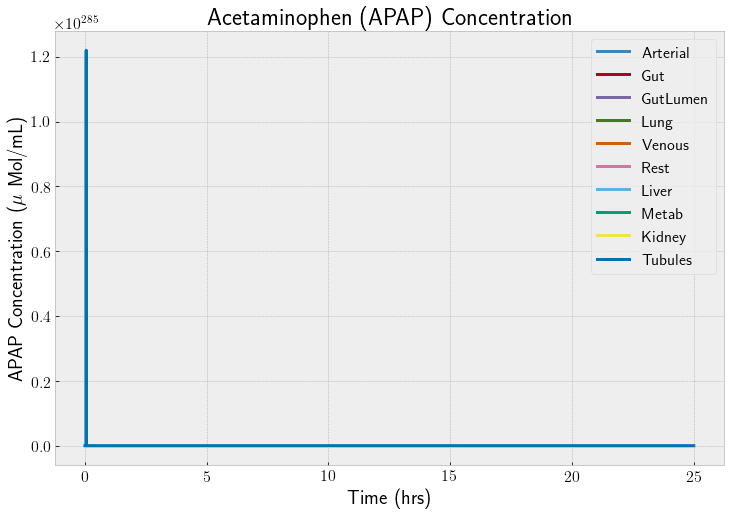

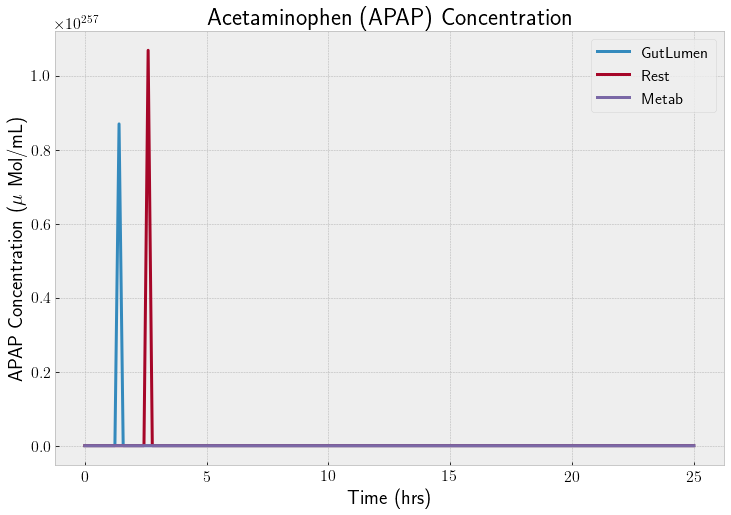

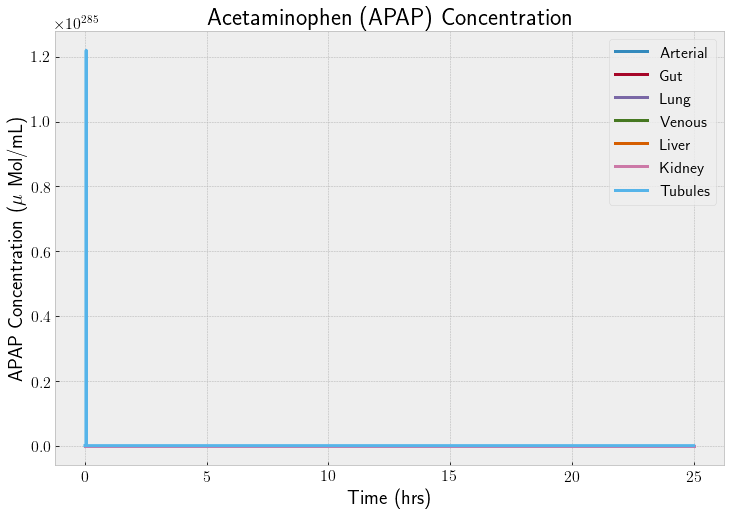

In [87]:
# Graph solution
# change plot display style
# plt.style.use('dark_background')
# plt.style.use('classic')
plt.style.use('bmh')
# plt.style.use('seaborn-dark')
# print(plt.style.available)
plt.rcParams['font.size'] = 22
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 10
plt.rcParams['text.usetex'] = True

compartments = dynamics

# Create plots with pre-defined labels.
fig, ax = plt.subplots(figsize=(12,8))
for c in compartments:
      ax.plot(t, xB[:, c], label=names[c])
plt.xlabel('Time (hrs)')
plt.ylabel(r'APAP Concentration ($\mu$ Mol/mL)')
plt.title('Acetaminophen (APAP) Concentration')
ax.legend(loc='upper right')
plt.show()

compartments = [2,5,7]

# Create plots with pre-defined labels.
fig, ax = plt.subplots(figsize=(12,8))
for c in compartments:
      ax.plot(t, xB[:, c], label=names[c])
plt.xlabel('Time (hrs)')
plt.ylabel(r'APAP Concentration ($\mu$ Mol/mL)')
plt.title('Acetaminophen (APAP) Concentration')
ax.legend(loc='upper right')
plt.show()

compartments = [0,1,3,4,6,8,9]

# Create plots with pre-defined labels.
fig, ax = plt.subplots(figsize=(12,8))
for c in compartments:
      ax.plot(t, xB[:, c], label=names[c])
plt.xlabel('Time (hrs)')
plt.ylabel(r'APAP Concentration ($\mu$ Mol/mL)')
plt.title('Acetaminophen (APAP) Concentration')
ax.legend(loc='upper right')
plt.show()